# Import

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import sys
import os
parent_dir = os.path.abspath('..')
sys.path.insert(1, parent_dir)

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score
import shap
from imblearn.under_sampling import RandomUnderSampler
import re
from sklearn.utils.class_weight import compute_class_weight
import pickle

In [64]:
from tools.functions import missing_values_summary, unique_value_counts, pct_null_buckets, test_scores

In [65]:
from tools import KernelPreproc

In [66]:
from tools.mlflow_tracking import log_model, log_model_wo_pipe

# Exploration

In [67]:
csv_path = os.path.join(parent_dir, "data")
file_names = [f for f in os.listdir(csv_path) if f.endswith(".csv")]
file_names

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'data.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

## application_test

In [68]:
file = file_names[0]
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


In [70]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
47,COMMONAREA_AVG,33495,15249,68.716150
61,COMMONAREA_MODE,33495,15249,68.716150
75,COMMONAREA_MEDI,33495,15249,68.716150
55,NONLIVINGAPARTMENTS_AVG,33347,15397,68.412523
69,NONLIVINGAPARTMENTS_MODE,33347,15397,68.412523
...,...,...,...,...
14,NAME_HOUSING_TYPE,0,48744,0.000000
13,NAME_FAMILY_STATUS,0,48744,0.000000
12,NAME_EDUCATION_TYPE,0,48744,0.000000
11,NAME_INCOME_TYPE,0,48744,0.000000


## application_train

In [71]:
file = file_names[1]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

application_train.csv


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [73]:
cols = ['SK_ID_CURR', 'TARGET']
temp = missing_values_summary(data, ascending=False)
temp[temp['index'].isin(cols)]

,index,Null_counts,Non_Null_counts,Percentage_Null
1,TARGET,0,307511,0.0
0,SK_ID_CURR,0,307511,0.0


In [74]:
unique_value_counts(data, 'TARGET')

,label,counts,percent,percent_cumul
0,0,282686,91.927118,91.927118
1,1,24825,8.072882,100.000000


In [75]:
data['SK_ID_CURR'].nunique()

307511

In the application_train dataset, there are 92% of the applications that are refused.

## bureau

In [76]:
file = file_names[2]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

bureau.csv


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [78]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
16,AMT_ANNUITY,1226791,489637,71.473490
8,AMT_CREDIT_MAX_OVERDUE,1124488,591940,65.513264
7,DAYS_ENDDATE_FACT,633653,1082775,36.916958
12,AMT_CREDIT_SUM_LIMIT,591780,1124648,34.477415
11,AMT_CREDIT_SUM_DEBT,257669,1458759,15.011932
6,DAYS_CREDIT_ENDDATE,105553,1610875,6.149573
10,AMT_CREDIT_SUM,13,1716415,0.000757
2,CREDIT_ACTIVE,0,1716428,0.000000
3,CREDIT_CURRENCY,0,1716428,0.000000
4,DAYS_CREDIT,0,1716428,0.000000


In [79]:
data['SK_ID_CURR'].nunique()

305811

## bureau_balance

In [80]:
file = file_names[3]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

bureau_balance.csv


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [81]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [82]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
0,SK_ID_BUREAU,0,27299925,0.0
1,MONTHS_BALANCE,0,27299925,0.0
2,STATUS,0,27299925,0.0


## credit_card_balance

In [83]:
file = file_names[4]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

credit_card_balance.csv


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [85]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
10,AMT_PAYMENT_CURRENT,767988,3072324,19.998063
5,AMT_DRAWINGS_ATM_CURRENT,749816,3090496,19.524872
18,CNT_DRAWINGS_POS_CURRENT,749816,3090496,19.524872
7,AMT_DRAWINGS_OTHER_CURRENT,749816,3090496,19.524872
8,AMT_DRAWINGS_POS_CURRENT,749816,3090496,19.524872
17,CNT_DRAWINGS_OTHER_CURRENT,749816,3090496,19.524872
15,CNT_DRAWINGS_ATM_CURRENT,749816,3090496,19.524872
19,CNT_INSTALMENT_MATURE_CUM,305236,3535076,7.948208
9,AMT_INST_MIN_REGULARITY,305236,3535076,7.948208
0,SK_ID_PREV,0,3840312,0.000000


## HomeCredit_columns_description

In [86]:
file = file_names[5]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path, encoding = 'unicode_escape')
data.head()

data.csv


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: float64(621), int64(176)
memory usage: 1.8 GB


In [88]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
596,REFUSED_AMT_DOWN_PAYMENT_MAX,262339,45168,85.311554
597,REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,45168,85.311554
595,REFUSED_AMT_DOWN_PAYMENT_MIN,262339,45168,85.311554
606,REFUSED_RATE_DOWN_PAYMENT_MEAN,262339,45168,85.311554
605,REFUSED_RATE_DOWN_PAYMENT_MAX,262339,45168,85.311554
...,...,...,...,...
179,ORGANIZATION_TYPE_Government,0,307507,0.000000
178,ORGANIZATION_TYPE_Emergency,0,307507,0.000000
177,ORGANIZATION_TYPE_Electricity,0,307507,0.000000
176,ORGANIZATION_TYPE_Culture,0,307507,0.000000


## installments_payments

In [89]:
file = file_names[6]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path, encoding = "ISO-8859-1")
data.head()

HomeCredit_columns_description.csv


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


In [91]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
4,Special,133,86,60.730594
0,Unnamed: 0,0,219,0.000000
1,Table,0,219,0.000000
2,Row,0,219,0.000000
3,Description,0,219,0.000000


## POS_CASH_balance

In [92]:
file = file_names[7]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

installments_payments.csv


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [94]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
5,DAYS_ENTRY_PAYMENT,2905,13602496,0.021352
7,AMT_PAYMENT,2905,13602496,0.021352
0,SK_ID_PREV,0,13605401,0.000000
1,SK_ID_CURR,0,13605401,0.000000
2,NUM_INSTALMENT_VERSION,0,13605401,0.000000
3,NUM_INSTALMENT_NUMBER,0,13605401,0.000000
4,DAYS_INSTALMENT,0,13605401,0.000000
6,AMT_INSTALMENT,0,13605401,0.000000


## previous_application

In [95]:
file = file_names[8]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

POS_CASH_balance.csv


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [97]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
4,CNT_INSTALMENT_FUTURE,26087,9975271,0.260835
3,CNT_INSTALMENT,26071,9975287,0.260675
0,SK_ID_PREV,0,10001358,0.000000
1,SK_ID_CURR,0,10001358,0.000000
2,MONTHS_BALANCE,0,10001358,0.000000
5,NAME_CONTRACT_STATUS,0,10001358,0.000000
6,SK_DPD,0,10001358,0.000000
7,SK_DPD_DEF,0,10001358,0.000000


## sample_submission

In [98]:
file = file_names[9]
print(file)
path = os.path.join('..','data', file)
data = pd.read_csv(path)
data.head()

previous_application.csv


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [100]:
temp = missing_values_summary(data, ascending=False)
temp

,index,Null_counts,Non_Null_counts,Percentage_Null
14,RATE_INTEREST_PRIVILEGED,1664263,5951,99.643698
13,RATE_INTEREST_PRIMARY,1664263,5951,99.643698
6,AMT_DOWN_PAYMENT,895844,774370,53.636480
12,RATE_DOWN_PAYMENT,895844,774370,53.636480
20,NAME_TYPE_SUITE,820405,849809,49.119754
36,NFLAG_INSURED_ON_APPROVAL,673065,997149,40.298129
35,DAYS_TERMINATION,673065,997149,40.298129
34,DAYS_LAST_DUE,673065,997149,40.298129
33,DAYS_LAST_DUE_1ST_VERSION,673065,997149,40.298129
32,DAYS_FIRST_DUE,673065,997149,40.298129


In [101]:
# data['TARGET'].value_counts()

# Data preprocessing

In [102]:
file_path = os.path.join(parent_dir, "data", "data.csv")

In [103]:
# data = KernelPreproc.main()
# data.to_csv(file_path, index=False)

In [104]:
data = pd.read_csv(file_path)
data.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing data

<AxesSubplot: xlabel='Percentage_Null', ylabel='Count'>

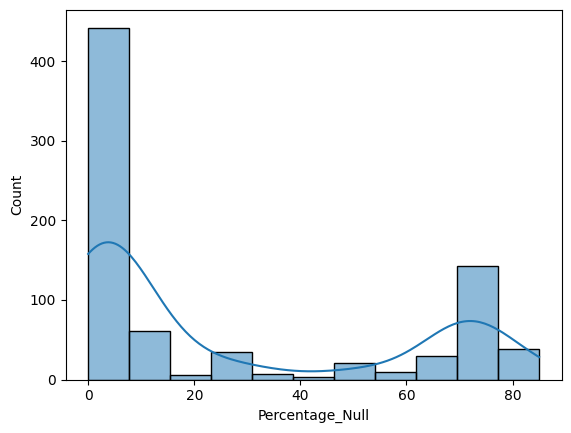

In [105]:
temp = missing_values_summary(data, ascending=False)
temp['Percentage_Null'] = temp['Percentage_Null'].apply(lambda x: round(x,0))
sns.histplot(temp['Percentage_Null'], kde=True)

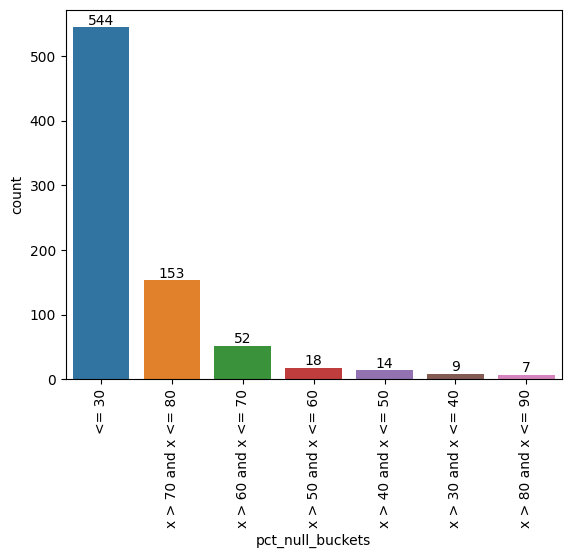

In [106]:
temp['pct_null_buckets'] = temp['Percentage_Null'].apply(lambda x: pct_null_buckets(x))

ax = sns.countplot(x=temp['pct_null_buckets'],
                   order=temp['pct_null_buckets'].value_counts(ascending=False).index)
abs_values = temp['pct_null_buckets'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
plt.xticks(rotation=90);

In [107]:
cols_to_drop = list(temp[temp['Percentage_Null'] > 30]['index'])
cols = list(data.columns)
cols_to_keep = [col for col in cols if col not in cols_to_drop]

print(f"nb cols_to_drop: {len(cols_to_drop)}")
print(f"nb cols: {len(cols)}")
print(f"nb cols_to_keep: {len(cols_to_keep)}")

nb cols_to_drop: 253
nb cols: 797
nb cols_to_keep: 544


In [108]:
df = data.copy()
df = df[cols_to_keep]
df.shape

(307507, 544)

## Outliers

In [109]:
temp = df.describe()
temp.loc['max'].max()

inf

In [110]:
# Drop inf values
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [111]:
# Check
temp = df.describe()
temp.loc['max'].max()

445993643959.2246

## Data

In [112]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Simulation

In [114]:
# !cd .\OC-P7\notebooks
# !pipenv shell
# !mlflow ui

## SMOTE

### Dummy

In [115]:
imputer = SimpleImputer(strategy="mean")
imputer.fit(X_train)
X_train_imputer = imputer.transform(X_train)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_imputer, y_train)

X_test_imputer = imputer.transform(X_test)
y_pred = dummy.predict(X_test_imputer)

print("accuracy_score:", dummy.score(X_train, y_train))
print("accuracy_score:", dummy.score(X_test, y_test))
print("fbeta_score:", fbeta_score(y_test, y_pred, beta=2)) # recall FN

accuracy_score: 0.9191909118501496
accuracy_score: 0.9195077851633128
fbeta_score: 0.0


### LGBM

In [116]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('model', LGBMClassifier()),
])

grid = {
    'model__num_leaves': [50, 100, 500], # [31, 10000, 50000]
    'model__min_data_in_leaf': [100, 500], #[100, 1000],
    'model__max_depth': [-1, 10] # [-1, 10, 100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)
# fit_time: 11m

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGB

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE(sampling_strategy=0.5)),
                                       ('model', LGBMClassifier())]),
             param_grid={'model__max_depth': [-1, 10],
                         'model__min_data_in_leaf': [100, 500],
                         'model__num_leaves': [50, 100, 500]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-24" - id "966063637948665005"
Logging run: LGBMClassifier()_14:03:41
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_data_in_leaf logged
- model__num_leaves logged
- roc_curve.png logged
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
- score_fbeta_test logged
Finished logging


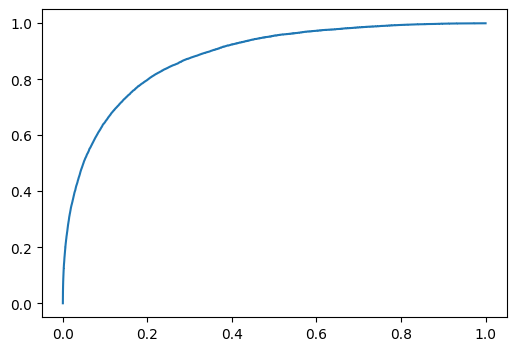

In [117]:
# MLflow
log_model(search, X_train, y_train, X_test, y_test)

In [118]:
scores = test_scores(search, X_test, y_test)
scores

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
accuracy_score: 0.9393186518724717
fbeta_score: 0.2921719955898567


,score,value
0,accuracy_score,0.939319
1,fbeta_score,0.292172


### Catboost

In [119]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('model', CatBoostClassifier(num_trees=100)),
])

grid = {
    'model__depth': [4, 10], #7,
    'model__learning_rate': [0.04, 0.1], #0.01, 
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)
# fit_time: 19m

0:	learn: 0.6452454	total: 377ms	remaining: 37.3s
1:	learn: 0.6138131	total: 598ms	remaining: 29.3s
2:	learn: 0.5756256	total: 823ms	remaining: 26.6s
3:	learn: 0.5499032	total: 1.04s	remaining: 25s
4:	learn: 0.5228557	total: 1.22s	remaining: 23.2s
5:	learn: 0.5026717	total: 1.44s	remaining: 22.5s
6:	learn: 0.4807070	total: 1.67s	remaining: 22.2s
7:	learn: 0.4577171	total: 1.88s	remaining: 21.7s
8:	learn: 0.4384265	total: 2.12s	remaining: 21.4s
9:	learn: 0.4241278	total: 2.31s	remaining: 20.8s
10:	learn: 0.4149378	total: 2.52s	remaining: 20.4s
11:	learn: 0.4007832	total: 2.73s	remaining: 20s
12:	learn: 0.3889280	total: 2.94s	remaining: 19.6s
13:	learn: 0.3779563	total: 3.12s	remaining: 19.2s
14:	learn: 0.3685662	total: 3.35s	remaining: 19s
15:	learn: 0.3600994	total: 3.57s	remaining: 18.7s
16:	learn: 0.3510886	total: 3.79s	remaining: 18.5s
17:	learn: 0.3404177	total: 4.03s	remaining: 18.3s
18:	learn: 0.3304520	total: 4.25s	remaining: 18.1s
19:	learn: 0.3221570	total: 4.46s	remaining: 17

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE(sampling_strategy=0.5)),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001B586A2A520>)]),
             param_grid={'model__depth': [4, 10],
                         'model__learning_rate': [0.04, 0.1]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-24" - id "966063637948665005"
Logging run: <catboost.core.CatBoostClassifier object at 0x000001B586A2A520>_14:28:30
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__depth logged
- model__learning_rate logged
- roc_curve.png logged
0:	learn: 0.5758939	total: 1.58s	remaining: 2m 36s
1:	learn: 0.4949908	total: 3.26s	remaining: 2m 39s
2:	learn: 0.4328312	total: 4.91s	remaining: 2m 38s
3:	learn: 0.3898348	total: 6.61s	remaining: 2m 38s
4:	learn: 0.3486589	total: 8.29s	remaining: 2m 37s
5:	learn: 0.3223901	total: 9.9s	remaining: 2m 35s
6:	learn: 0.2991878	total: 11.7s	remaining: 2m 34s
7:	learn: 0.2809737	total: 13.3s	remaining: 2m 33s
8:	learn: 0.2691748	total: 15.1s	remaining: 2m 32s
9:	learn: 0.2561555	total: 16.8s	remaining: 2m 30s
10:	learn: 0.2457883	total: 18.5s	remaining: 2m 29s
11:	learn: 0.2371505	total: 20.1s	remaining: 2m 27s
12:	learn: 0.2

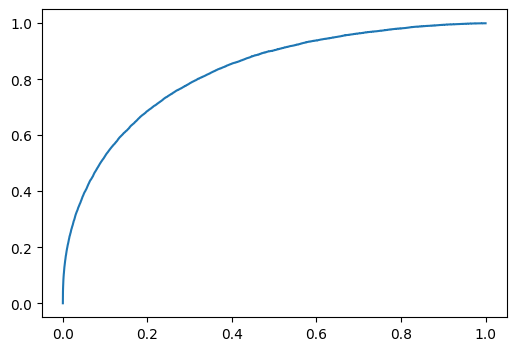

In [120]:
# MLflow
log_model(search, X_train, y_train, X_test, y_test)

In [121]:
scores = test_scores(search, X_test, y_test)
scores

0:	learn: 0.5788073	total: 1.57s	remaining: 2m 35s
1:	learn: 0.5021599	total: 3.24s	remaining: 2m 38s
2:	learn: 0.4411758	total: 4.9s	remaining: 2m 38s
3:	learn: 0.3943700	total: 6.6s	remaining: 2m 38s
4:	learn: 0.3512256	total: 8.33s	remaining: 2m 38s
5:	learn: 0.3224084	total: 9.91s	remaining: 2m 35s
6:	learn: 0.3003928	total: 11.6s	remaining: 2m 33s
7:	learn: 0.2831885	total: 13.2s	remaining: 2m 31s
8:	learn: 0.2685706	total: 14.9s	remaining: 2m 30s
9:	learn: 0.2550745	total: 16.5s	remaining: 2m 28s
10:	learn: 0.2448304	total: 18.2s	remaining: 2m 27s
11:	learn: 0.2364343	total: 19.8s	remaining: 2m 25s
12:	learn: 0.2297626	total: 21.4s	remaining: 2m 23s
13:	learn: 0.2239203	total: 23.1s	remaining: 2m 21s
14:	learn: 0.2193628	total: 24.8s	remaining: 2m 20s
15:	learn: 0.2141968	total: 26.4s	remaining: 2m 18s
16:	learn: 0.2102318	total: 28.2s	remaining: 2m 17s
17:	learn: 0.2074270	total: 29.9s	remaining: 2m 16s
18:	learn: 0.2042464	total: 31.6s	remaining: 2m 14s
19:	learn: 0.2017540	tot

,score,value
0,accuracy_score,0.926233
1,fbeta_score,0.104764


### RandomForest

In [122]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('smote', SMOTE(sampling_strategy=0.5)),
    ('model', RandomForestClassifier(n_estimators=50)),
])

grid = {
    # 'model__bootstrap': [True, False],
    'model__max_depth': [10, 20],
    # 'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 4],
    'model__min_samples_split': [2, 5],
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)
# fit time: 19min

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('smote', SMOTE(sampling_strategy=0.5)),
                                       ('model',
                                        RandomForestClassifier(n_estimators=50))]),
             param_grid={'model__max_depth': [10, 20],
                         'model__min_samples_leaf': [1, 4],
                         'model__min_samples_split': [2, 5]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-24" - id "966063637948665005"
Logging run: RandomForestClassifier(n_estimators=50)_15:04:41
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_samples_leaf logged
- model__min_samples_split logged
- roc_curve.png logged
- score_fbeta_test logged
Finished logging


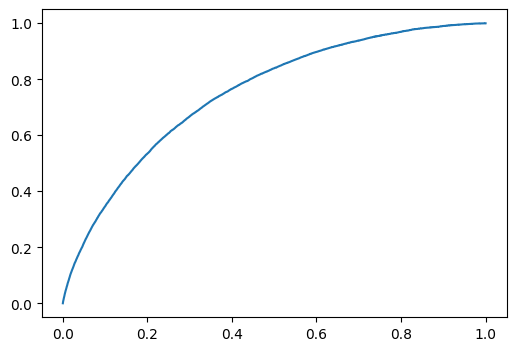

In [123]:
# MLflow
log_model(search, X_train, y_train, X_test, y_test)

In [124]:
scores = test_scores(search, X_test, y_test)
scores

accuracy_score: 0.9200541124133356
fbeta_score: 0.015684066596959704


,score,value
0,accuracy_score,0.920054
1,fbeta_score,0.015684


## Undersampling

### Data

In [125]:
print(df.shape)
df_wo_na = df.dropna()
print(df_wo_na.shape)

(307507, 544)
(102240, 544)


In [126]:
X = df_wo_na.drop(columns=['TARGET'])
y = df_wo_na['TARGET']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [128]:
rus = RandomUnderSampler(random_state=0, replacement=True)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

print('original dataset shape:', Counter(y_train))
print('Resample dataset shape', Counter(y_rus))

original dataset shape: Counter({0: 70487, 1: 6193})
Resample dataset shape Counter({0: 6193, 1: 6193})


In [129]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_rus.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_rus = X_rus.rename(columns=new_names)

In [130]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_test.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_test = X_test.rename(columns=new_names)

### Dummy

In [131]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_rus, y_rus)

y_pred = dummy.predict(X_test)

print("accuracy_score:", dummy.score(X_rus, y_rus))
print("accuracy_score:", dummy.score(X_test, y_test))
print("fbeta_score:", fbeta_score(y_test, y_pred, beta=2)) # recall FN

accuracy_score: 0.5
accuracy_score: 0.9185446009389672
fbeta_score: 0.0


### LGBM

In [132]:
pipe = Pipeline([
    ('model', LGBMClassifier()),
])

grid = {
    'model__num_leaves': [50, 100, 500], # [31, 10000, 50000]
    'model__min_data_in_leaf': [100, 500], #[100, 1000],
    'model__max_depth': [-1, 10] # [-1, 10, 100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_rus, y_rus)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGB

GridSearchCV(cv=2, estimator=Pipeline(steps=[('model', LGBMClassifier())]),
             param_grid={'model__max_depth': [-1, 10],
                         'model__min_data_in_leaf': [100, 500],
                         'model__num_leaves': [50, 100, 500]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-24" - id "966063637948665005"
Logging run: LGBMClassifier()_15:09:15
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_data_in_leaf logged
- model__num_leaves logged
- roc_curve.png logged
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
- score_fbeta_test logged
Finished logging


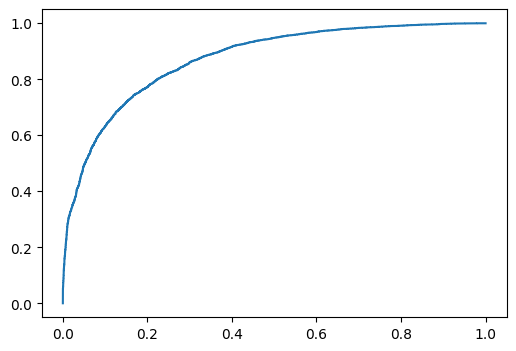

In [133]:
# MLflow
log_model_wo_pipe(search, X_rus, y_rus, X_test, y_test)

In [134]:
scores = test_scores(search, X_test, y_test)
scores

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
accuracy_score: 0.9384976525821597
fbeta_score: 0.29102622061482813


,score,value
0,accuracy_score,0.938498
1,fbeta_score,0.291026


### Catboost

In [135]:
pipe = Pipeline([
    ('model', CatBoostClassifier(num_trees=100)),
])

grid = {
    'model__depth': [4, 10], #7,
    'model__learning_rate': [0.04, 0.1], #0.01, 
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_rus, y_rus)

0:	learn: 0.6885250	total: 28.4ms	remaining: 2.81s
1:	learn: 0.6843903	total: 52.4ms	remaining: 2.57s
2:	learn: 0.6807620	total: 79.4ms	remaining: 2.57s
3:	learn: 0.6774964	total: 103ms	remaining: 2.46s
4:	learn: 0.6740294	total: 127ms	remaining: 2.41s
5:	learn: 0.6710307	total: 150ms	remaining: 2.34s
6:	learn: 0.6683020	total: 173ms	remaining: 2.29s
7:	learn: 0.6655597	total: 195ms	remaining: 2.24s
8:	learn: 0.6630679	total: 220ms	remaining: 2.23s
9:	learn: 0.6606860	total: 244ms	remaining: 2.19s
10:	learn: 0.6581075	total: 273ms	remaining: 2.21s
11:	learn: 0.6561172	total: 297ms	remaining: 2.18s
12:	learn: 0.6540970	total: 322ms	remaining: 2.15s
13:	learn: 0.6521613	total: 346ms	remaining: 2.12s
14:	learn: 0.6503892	total: 376ms	remaining: 2.13s
15:	learn: 0.6482565	total: 399ms	remaining: 2.1s
16:	learn: 0.6461074	total: 426ms	remaining: 2.08s
17:	learn: 0.6447633	total: 451ms	remaining: 2.05s
18:	learn: 0.6432299	total: 474ms	remaining: 2.02s
19:	learn: 0.6415731	total: 498ms	remai

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001B587D80550>)]),
             param_grid={'model__depth': [4, 10],
                         'model__learning_rate': [0.04, 0.1]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-24" - id "966063637948665005"
Logging run: <catboost.core.CatBoostClassifier object at 0x000001B587D80550>_15:15:35
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__depth logged
- model__learning_rate logged
- roc_curve.png logged
0:	learn: 0.5925279	total: 630ms	remaining: 1m 2s
1:	learn: 0.5180155	total: 1.26s	remaining: 1m 1s
2:	learn: 0.4619648	total: 1.89s	remaining: 1m 1s
3:	learn: 0.4144260	total: 2.54s	remaining: 1m
4:	learn: 0.3775144	total: 3.2s	remaining: 1m
5:	learn: 0.3520426	total: 3.86s	remaining: 1m
6:	learn: 0.3299204	total: 4.52s	remaining: 1m
7:	learn: 0.3142871	total: 5.17s	remaining: 59.4s
8:	learn: 0.2994394	total: 5.83s	remaining: 58.9s
9:	learn: 0.2882134	total: 6.46s	remaining: 58.2s
10:	learn: 0.2790235	total: 7.13s	remaining: 57.7s
11:	learn: 0.2706414	total: 7.79s	remaining: 57.2s
12:	learn: 0.2650149	total: 8.42s	rema

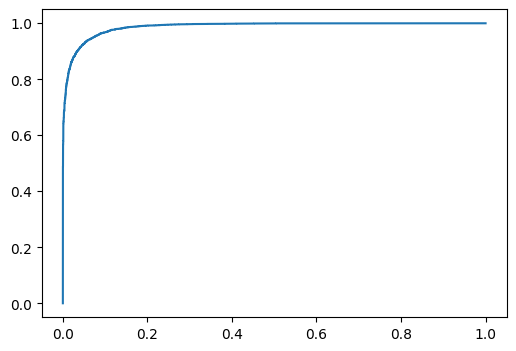

In [136]:
# MLflow
log_model_wo_pipe(search, X_rus, y_rus, X_test, y_test)

In [137]:
scores = test_scores(search, X_test, y_test)
scores

0:	learn: 0.5925279	total: 696ms	remaining: 1m 8s
1:	learn: 0.5180155	total: 1.34s	remaining: 1m 5s
2:	learn: 0.4619648	total: 1.99s	remaining: 1m 4s
3:	learn: 0.4144260	total: 2.62s	remaining: 1m 2s
4:	learn: 0.3775144	total: 3.25s	remaining: 1m 1s
5:	learn: 0.3520426	total: 3.91s	remaining: 1m 1s
6:	learn: 0.3299204	total: 4.54s	remaining: 1m
7:	learn: 0.3142871	total: 5.17s	remaining: 59.5s
8:	learn: 0.2994394	total: 5.82s	remaining: 58.9s
9:	learn: 0.2882134	total: 6.47s	remaining: 58.2s
10:	learn: 0.2790235	total: 7.12s	remaining: 57.6s
11:	learn: 0.2706414	total: 7.79s	remaining: 57.1s
12:	learn: 0.2650149	total: 8.43s	remaining: 56.4s
13:	learn: 0.2584668	total: 9.07s	remaining: 55.7s
14:	learn: 0.2531722	total: 9.72s	remaining: 55.1s
15:	learn: 0.2482702	total: 10.4s	remaining: 54.4s
16:	learn: 0.2434214	total: 11s	remaining: 53.8s
17:	learn: 0.2406757	total: 11.7s	remaining: 53.2s
18:	learn: 0.2373971	total: 12.4s	remaining: 52.7s
19:	learn: 0.2336232	total: 13s	remaining: 52s

,score,value
0,accuracy_score,0.942723
1,fbeta_score,0.345406


### RandomForest

In [138]:
pipe = Pipeline([
    ('model', RandomForestClassifier(n_estimators=50)),
])

grid = {
    # 'model__bootstrap': [True, False],
    'model__max_depth': [10, 20],
    # 'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 4],
    'model__min_samples_split': [2, 5],
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_rus, y_rus)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(n_estimators=50))]),
             param_grid={'model__max_depth': [10, 20],
                         'model__min_samples_leaf': [1, 4],
                         'model__min_samples_split': [2, 5]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-24" - id "966063637948665005"
Logging run: RandomForestClassifier(n_estimators=50)_15:19:27
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_samples_leaf logged
- model__min_samples_split logged
- roc_curve.png logged
- score_fbeta_test logged
Finished logging


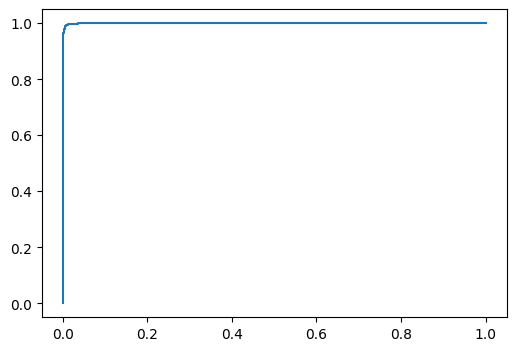

In [139]:
# MLflow
log_model_wo_pipe(search, X_rus, y_rus, X_test, y_test)

In [140]:
scores = test_scores(search, X_test, y_test)
scores

accuracy_score: 0.9280907668231612
fbeta_score: 0.14232384507699486


,score,value
0,accuracy_score,0.928091
1,fbeta_score,0.142324


## Class Weights

### Data

In [141]:
X = df_wo_na.drop(columns=['TARGET'])
y = df_wo_na['TARGET']

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

In [143]:
print('original dataset shape:', Counter(y_train))
print('weight class 0:', f'{Counter(y_train)[0]/y_train.shape[0]:.2f}', 'weight class 1:', f'{Counter(y_train)[1]/y_train.shape[0]:.2f}')

original dataset shape: Counter({0: 70487, 1: 6193})
weight class 0: 0.92 weight class 1: 0.08


In [144]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.5439300863989104, 1: 6.1908606491199745}

In [145]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_train.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_train = X_train.rename(columns=new_names)

In [146]:
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_test.columns}
new_n_list = list(new_names.values())
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_test = X_test.rename(columns=new_names)

### Dummy

In [147]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

print("accuracy_score:", dummy.score(X_train, y_train))
print("accuracy_score:", dummy.score(X_test, y_test))
print("fbeta_score:", fbeta_score(y_test, y_pred, beta=2)) # recall FN

accuracy_score: 0.9192357850808555
accuracy_score: 0.9185446009389672
fbeta_score: 0.0


### LGBM

In [148]:
pipe = Pipeline([
    ('model', LGBMClassifier(class_weight='balanced')),
])

grid = {
    'model__num_leaves': [50, 100, 500], # [31, 10000, 50000]
    'model__min_data_in_leaf': [100, 500], #[100, 1000],
    'model__max_depth': [-1, 10] # [-1, 10, 100]
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGB

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        LGBMClassifier(class_weight='balanced'))]),
             param_grid={'model__max_depth': [-1, 10],
                         'model__min_data_in_leaf': [100, 500],
                         'model__num_leaves': [50, 100, 500]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-24" - id "966063637948665005"
Logging run: LGBMClassifier(class_weight='balanced')_15:23:10
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_data_in_leaf logged
- model__num_leaves logged
- roc_curve.png logged
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
- score_fbeta_test logged
Finished logging


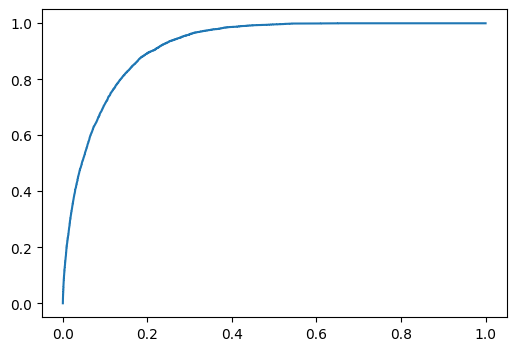

In [149]:
# MLflow
log_model_wo_pipe(search, X_train, y_train, X_test, y_test)

In [150]:
scores = test_scores(search, X_test, y_test)
scores

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
accuracy_score: 0.8798122065727699
fbeta_score: 0.7594889420203228


,score,value
0,accuracy_score,0.879812
1,fbeta_score,0.759489


### Catboost

In [151]:
pipe = Pipeline([
    ('model', CatBoostClassifier(num_trees=100, class_weights=class_weights)),
])

grid = {
    'model__depth': [4, 10], #7,
    'model__learning_rate': [0.04, 0.1], #0.01, 
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)

0:	learn: 0.6891834	total: 43.1ms	remaining: 4.26s
1:	learn: 0.6847271	total: 83.2ms	remaining: 4.08s
2:	learn: 0.6807672	total: 123ms	remaining: 3.99s
3:	learn: 0.6774739	total: 168ms	remaining: 4.02s
4:	learn: 0.6740395	total: 214ms	remaining: 4.06s
5:	learn: 0.6708415	total: 258ms	remaining: 4.05s
6:	learn: 0.6676961	total: 299ms	remaining: 3.97s
7:	learn: 0.6646888	total: 341ms	remaining: 3.92s
8:	learn: 0.6619007	total: 386ms	remaining: 3.9s
9:	learn: 0.6592362	total: 428ms	remaining: 3.85s
10:	learn: 0.6570068	total: 465ms	remaining: 3.76s
11:	learn: 0.6549860	total: 514ms	remaining: 3.77s
12:	learn: 0.6528567	total: 551ms	remaining: 3.69s
13:	learn: 0.6506084	total: 596ms	remaining: 3.66s
14:	learn: 0.6486299	total: 634ms	remaining: 3.6s
15:	learn: 0.6466767	total: 675ms	remaining: 3.54s
16:	learn: 0.6449005	total: 720ms	remaining: 3.51s
17:	learn: 0.6432341	total: 759ms	remaining: 3.46s
18:	learn: 0.6419604	total: 799ms	remaining: 3.41s
19:	learn: 0.6403189	total: 842ms	remaini

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001B6335CEE20>)]),
             param_grid={'model__depth': [4, 10],
                         'model__learning_rate': [0.04, 0.1]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-24" - id "966063637948665005"
Logging run: <catboost.core.CatBoostClassifier object at 0x000001B6335CEE20>_15:28:45
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__depth logged
- model__learning_rate logged
- roc_curve.png logged
0:	learn: 0.6797929	total: 36.6ms	remaining: 3.62s
1:	learn: 0.6696979	total: 78.4ms	remaining: 3.84s
2:	learn: 0.6601288	total: 115ms	remaining: 3.73s
3:	learn: 0.6527124	total: 164ms	remaining: 3.94s
4:	learn: 0.6462367	total: 216ms	remaining: 4.1s
5:	learn: 0.6408673	total: 261ms	remaining: 4.08s
6:	learn: 0.6367610	total: 302ms	remaining: 4.02s
7:	learn: 0.6326556	total: 342ms	remaining: 3.94s
8:	learn: 0.6287493	total: 376ms	remaining: 3.8s
9:	learn: 0.6250504	total: 414ms	remaining: 3.73s
10:	learn: 0.6218481	total: 449ms	remaining: 3.63s
11:	learn: 0.6198465	total: 486ms	remaining: 3.56s
12:	learn: 0.6168180	tota

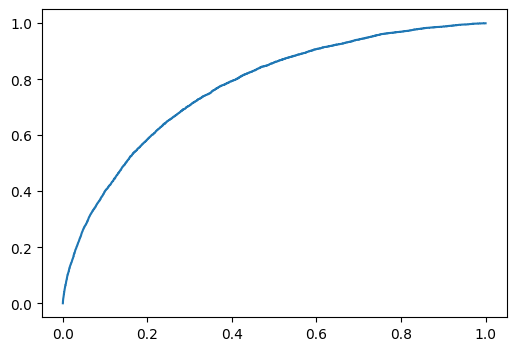

In [152]:
# MLflow
log_model_wo_pipe(search, X_train, y_train, X_test, y_test)

In [153]:
scores = test_scores(search, X_test, y_test)
scores

0:	learn: 0.6797929	total: 36ms	remaining: 3.56s
1:	learn: 0.6696979	total: 69.5ms	remaining: 3.4s
2:	learn: 0.6601288	total: 108ms	remaining: 3.48s
3:	learn: 0.6527124	total: 147ms	remaining: 3.54s
4:	learn: 0.6462367	total: 184ms	remaining: 3.5s
5:	learn: 0.6408673	total: 221ms	remaining: 3.46s
6:	learn: 0.6367610	total: 255ms	remaining: 3.38s
7:	learn: 0.6326556	total: 293ms	remaining: 3.37s
8:	learn: 0.6287493	total: 327ms	remaining: 3.31s
9:	learn: 0.6250504	total: 363ms	remaining: 3.27s
10:	learn: 0.6218481	total: 397ms	remaining: 3.21s
11:	learn: 0.6198465	total: 429ms	remaining: 3.14s
12:	learn: 0.6168180	total: 463ms	remaining: 3.1s
13:	learn: 0.6143885	total: 498ms	remaining: 3.06s
14:	learn: 0.6125718	total: 534ms	remaining: 3.03s
15:	learn: 0.6105290	total: 568ms	remaining: 2.98s
16:	learn: 0.6086832	total: 604ms	remaining: 2.95s
17:	learn: 0.6061233	total: 637ms	remaining: 2.9s
18:	learn: 0.6044777	total: 668ms	remaining: 2.85s
19:	learn: 0.6030223	total: 703ms	remaining: 

,score,value
0,accuracy_score,0.728404
1,fbeta_score,0.475810


### RandomForest

In [154]:
pipe = Pipeline([
    ('model', RandomForestClassifier(n_estimators=50, class_weight='balanced')),
])

grid = {
    # 'model__bootstrap': [True, False],
    'model__max_depth': [10, 20],
    # 'model__max_features': ['auto', 'sqrt'],
    'model__min_samples_leaf': [1, 4],
    'model__min_samples_split': [2, 5],
}

scorers = {
    'score_accuracy': 'accuracy',
    'score_roc_auc': 'roc_auc',
    'score_f1': 'f1',
    'score_fbeta': make_scorer(fbeta_score, beta=2, greater_is_better=True)  # recall FN
}

search = GridSearchCV(pipe, grid, scoring=scorers, refit='score_fbeta', cv=2, pre_dispatch=2*-1) # cv=5, n_jobs=-1
search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('model',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_estimators=50))]),
             param_grid={'model__max_depth': [10, 20],
                         'model__min_samples_leaf': [1, 4],
                         'model__min_samples_split': [2, 5]},
             pre_dispatch=-2, refit='score_fbeta',
             scoring={'score_accuracy': 'accuracy', 'score_f1': 'f1',
                      'score_fbeta': make_scorer(fbeta_score, beta=2),
                      'score_roc_auc': 'roc_auc'})

Active experiment name "2023-02-24" - id "966063637948665005"
Logging run: RandomForestClassifier(class_weight='balanced', n_estimators=50)_15:38:32
- model logged
- score_fit_time logged
- score_accuracy logged
- score_roc_auc logged
- score_f1 logged
- score_fbeta logged
- score_pred_time logged
- model__max_depth logged
- model__min_samples_leaf logged
- model__min_samples_split logged
- roc_curve.png logged
- score_fbeta_test logged
Finished logging


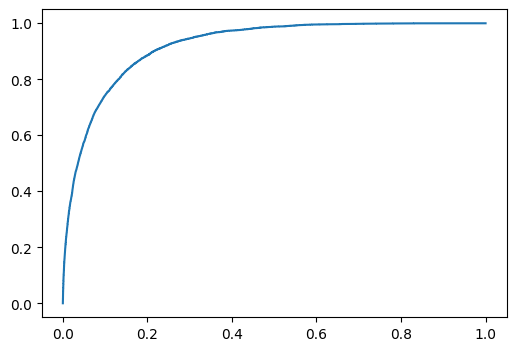

In [155]:
# MLflow
log_model_wo_pipe(search, X_train, y_train, X_test, y_test)

In [156]:
scores = test_scores(search, X_test, y_test)
scores

accuracy_score: 0.9408059467918622
fbeta_score: 0.7908185743237289


,score,value
0,accuracy_score,0.940806
1,fbeta_score,0.790819


# Best model

In [178]:
model_path = 'mlruns/966063637948665005/a2cd557f418b4b81a6f694c7dbc4d55e/artifacts/model/model.pkl'
best_model = pickle.load(open(model_path, "rb"))
best_model = best_model[0]
best_model

LGBMClassifier(min_data_in_leaf=500, num_leaves=50)

In [158]:
# best_model = LGBMClassifier(min_data_in_leaf=500, num_leaves=50)
# best_model

## Optimal threshold

In [180]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [181]:
thresholds = list(np.arange(0.1, 1.0, 0.1))
thresholds_list = []
scores_list = []

y_prob = best_model.predict_proba(X)

for threshold in thresholds:
    y_pred = (y_prob[:,1]>=threshold).astype(int)
    score = fbeta_score(y, y_pred, beta=2)

    thresholds_list.append(threshold)
    scores_list.append(score)

thresholds_df = pd.DataFrame({"threshold": thresholds_list, "score": scores_list})
thresholds_df

,threshold,score
0,0.1,0.309004
1,0.2,0.333315
2,0.3,0.364687
3,0.4,0.393124
4,0.5,0.411283
5,0.6,0.414228
6,0.7,0.390009
7,0.8,0.308611
8,0.9,0.106483


In [185]:
opt_threshold = thresholds_df.iloc[thresholds_df['score'].idxmax()]['threshold']
opt_threshold

0.6

## Feature importance

In [187]:
choosen_instance = X_rus.loc[[0]]

explainer = shap.TreeExplainer(best_model)

shap_values = explainer.shap_values(choosen_instance)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


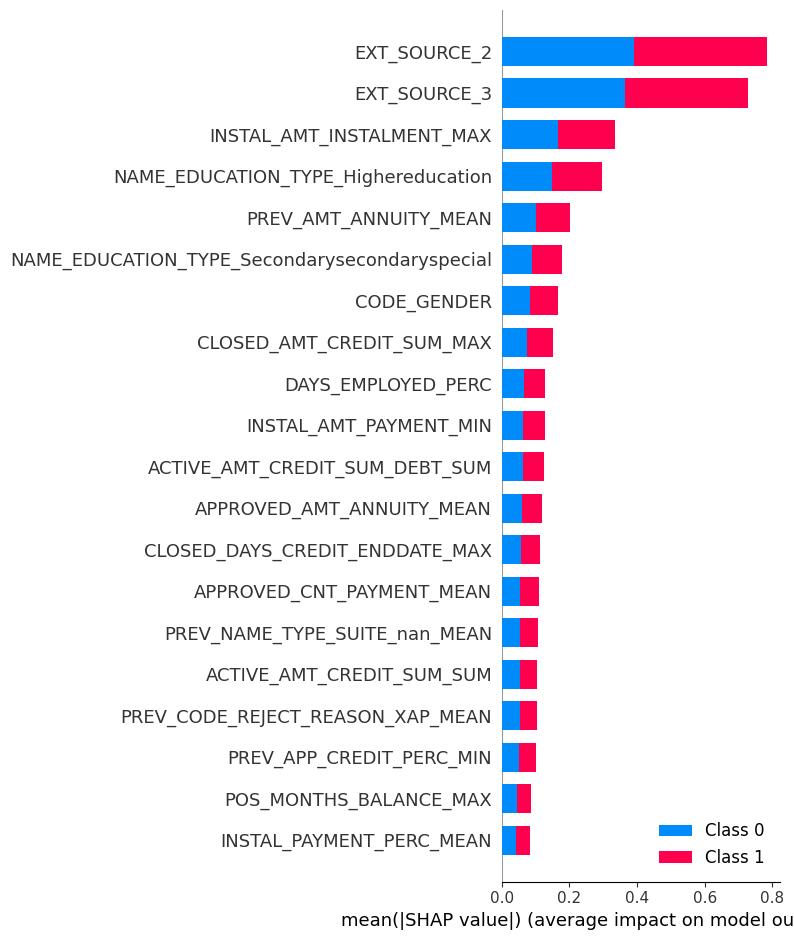

In [188]:
shap.summary_plot(shap_values, X_rus, plot_type='bar')